In [34]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sn

In [3]:
full_dataset = pd.read_csv('archive/Loan_status_2007-2020Q3.gzip')

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
full_dataset.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [54]:
small_dataset = full_dataset[-100000:]

In [55]:
columns = ['annual_inc', 'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'funded_amnt', 
           'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'pub_rec',
           'pub_rec_bankruptcies', 'revol_bal', 'term', 'total_acc', 'verification_status', 'loan_status']
df = small_dataset[columns]


In [56]:
df['loan_status'].unique()

array(['Current', 'Charged Off', 'Fully Paid', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [57]:
def clean_data(X):
    X = X.dropna()
    X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
    X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
    X['term'] = [float(re.sub('[a-zA-Z ]*', '', str(string))) for string in X['term']]
    X['home_ownership'] = (X['home_ownership'] == 'OWN').astype('int')
    X['verification_status'] = (X['verification_status'] != 'Verified') | (X['verification_status'] != 'Source Verified')
    X['verification_status'] = X['verification_status'].astype('int')
    # Remove emp title, issue_d before regression is run, can also try pd.get_dummies for emp_title 
    # Drop funded amount since it is equal to loan amount (Makes matrix singular)
    X = X.drop(columns=['emp_title', 'issue_d','funded_amnt'])
    
#     X['loan_status'] = (X['loan_status'] == 'Current') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'In Grace Period')
    X['loan_status'] = X['loan_status'] != 'Default'
    X['loan_status'] = X['loan_status'].astype('int')
    return X
  


In [58]:
df = clean_data(df)

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

In [52]:
df

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,pub_rec,pub_rec_bankruptcies,revol_bal,term,total_acc,verification_status,loan_status
2825493,104000.0,0.0,1.0,18.28,5.0,1,0.0,494.55,7.07,16000.0,0.0,0.0,20870.0,36.0,15.0,1,1
2825494,40000.0,0.0,0.0,16.11,10.0,0,0.0,519.44,10.42,16000.0,0.0,0.0,7448.0,36.0,9.0,1,1
2825495,160000.0,0.0,0.0,34.06,10.0,0,0.0,759.42,10.91,35000.0,0.0,0.0,120421.0,60.0,22.0,1,1
2825496,85500.0,0.0,0.0,21.45,10.0,0,0.0,259.58,19.03,10000.0,0.0,0.0,44861.0,60.0,22.0,1,1
2825498,117000.0,0.0,4.0,8.50,10.0,0,1.0,699.30,14.08,30000.0,1.0,0.0,13131.0,60.0,21.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,107000.0,1.0,3.0,11.65,1.0,0,1.0,690.30,23.99,24000.0,2.0,1.0,9688.0,60.0,24.0,1,1
2925489,65000.0,0.0,1.0,19.55,10.0,0,0.0,313.32,7.99,10000.0,0.0,0.0,9751.0,36.0,27.0,1,1
2925490,37000.0,0.0,0.0,20.56,8.0,0,1.0,358.26,16.99,10050.0,0.0,0.0,14300.0,36.0,21.0,1,1
2925491,41000.0,0.0,1.0,19.99,5.0,0,0.0,197.69,11.44,6000.0,0.0,0.0,1356.0,36.0,18.0,1,1


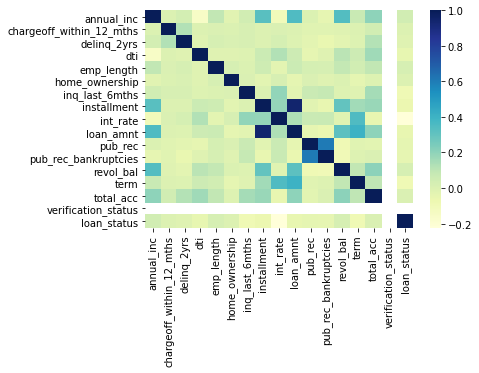

In [37]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, cmap="YlGnBu")
plt.show()

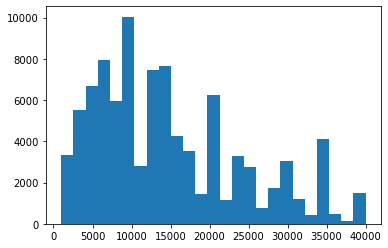

In [27]:
plt.hist(df['loan_amnt'], bins=25)
plt.show()

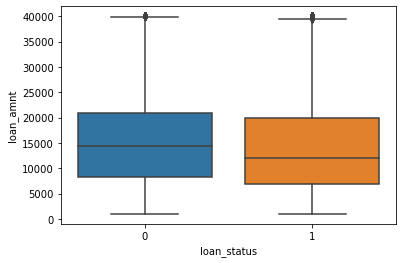

In [43]:
ax = sn.boxplot(y=df['loan_amnt'], x=df['loan_status'])

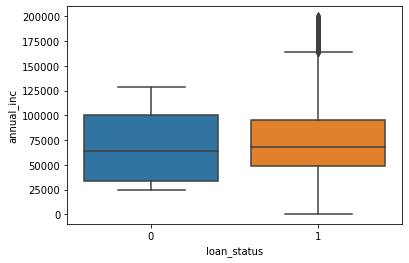

In [60]:
boxplot_df = df[df['annual_inc'] < 2*10**5] 
ax = sn.boxplot(y=boxplot_df['annual_inc'], x=boxplot_df['loan_status'])

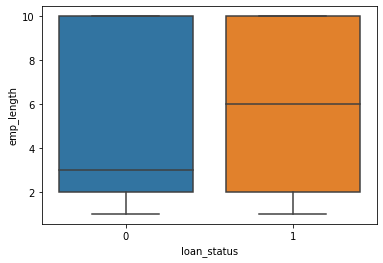

In [61]:
ax = sn.boxplot(y=df['emp_length'], x=df['loan_status'])

In [31]:
df.describe()

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,pub_rec,pub_rec_bankruptcies,revol_bal,term,total_acc,verification_status,loan_status
count,9.352200e+04,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,93522.000000,9.352200e+04,93522.000000,93522.000000,93522.0,93522.000000
mean,8.256821e+04,0.009014,0.361124,18.767088,5.965869,0.106531,0.510757,443.088773,13.293225,14828.927953,0.252625,0.136941,1.687787e+04,42.635016,23.921719,1.0,0.838808
std,6.943331e+04,0.103788,0.969994,11.862048,3.627879,0.308518,0.809515,281.495820,5.181166,9524.064599,0.656440,0.387865,2.326324e+04,10.733973,11.883470,0.0,0.367710
min,4.870000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,30.120000,5.320000,1000.000000,0.000000,0.000000,0.000000e+00,36.000000,2.000000,1.0,0.000000
25%,5.000000e+04,0.000000,0.000000,12.220000,2.000000,0.000000,0.000000,237.860000,9.930000,7200.000000,0.000000,0.000000,6.017000e+03,36.000000,15.000000,1.0,1.000000
50%,7.000000e+04,0.000000,0.000000,18.080000,6.000000,0.000000,0.000000,366.720000,12.620000,12000.000000,0.000000,0.000000,1.138100e+04,36.000000,22.000000,1.0,1.000000
75%,1.000000e+05,0.000000,0.000000,24.460000,10.000000,0.000000,1.000000,594.620000,15.990000,20000.000000,0.000000,0.000000,2.028700e+04,60.000000,30.000000,1.0,1.000000
max,8.900000e+06,4.000000,42.000000,999.000000,10.000000,1.000000,5.000000,1719.830000,30.990000,40000.000000,22.000000,7.000000,1.039013e+06,60.000000,146.000000,1.0,1.000000


In [19]:
X = df.drop(columns=['loan_status'])
# Still want to normalize but something weird is happening to data. Need more EDA.
# X = preprocessing.normalize(X)
# Note: Could also try multinomial logistic regression since the loan status doesnt necessarily have to be 0 or 1
# Perhaps cluster robust estimator by loan type or some other variable
Y = df['loan_status']
log_reg = sm.Logit(Y, X).fit()

         Current function value: inf
         Iterations: 35


/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [20]:
log_reg.summary()

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                93522
Model:                          Logit   Df Residuals:                    93506
Method:                           MLE   Df Model:                           15
Date:                Fri, 07 May 2021   Pseudo R-squ.:                    -inf
Time:                        19:25:54   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                       -41303.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1451.0516    169.416     -8.565      0.000   -1783.102   -1119.002
x2         -6573.4635   2.29e+05     -0.029      0.977   -4.55e+05    4.42e+05
x3         -4.752e+05   6.68e+04     -7.118      0.000   -6.06e+05   -3.44e+05
x4         -5.339e+05   6.23e+04     -8.566      0.000   -6.56e+05   -4.12e+05
x5          3.573e+05   4.19e+04      8.532      0.000    2.75e+05    4.39e+05
x6         -1353.9850   5.71e+04     -0.024      0.981   -1.13e+05    1.11e+05
x7          3.309e+05   4.71e+04      7.024      0.000    2.39e+05    4.23e+05
x8           -19.1187    755.413     -0.025      0.980   -1499.700    1461.463
x9           1.18e+06   1.38e+05      8.526      0.000    9.09e+05    1.45e+06
x10        -6180.9299    722.291     -8.557      0.000   -7596.593   -4765.266
x11          1.56e+05   5.02e+04      3.109      0.002    5.76e+04    2.54e+05
x12         1.005e+05   7.21e+04      1.394      0.163   -4.08e+04    2.42e+05
x13        -3305.2432    386.109     -8.560      0.000   -4062.004   -2548.483
x14          4.71e+06    5.5e+05      8.564      0.000    3.63e+06    5.79e+06
x15         2.365e+06   2.76e+05      8.569      0.000    1.82e+06    2.91e+06
x16          7.91e+04   2.27e+05      0.348      0.728   -3.66e+05    5.24e+05
==============================================================================

Possibly complete quasi-separation: A fraction 0.57 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
X = df.drop(columns=['loan_status'])
Y = df['loan_status']
model = LogisticRegression()
model.fit(X, Y)

In [268]:
model.coef_

array([[ 5.62469167e-06, -5.22602077e-05, -1.60177933e-03,
         1.20849822e-02,  4.15066669e-02,  1.01388216e-03,
        -1.09221898e-02,  4.57804720e-03, -1.16146233e-01,
        -1.65042109e-04, -2.32398960e-03, -1.50501512e-03,
         1.59617476e-08,  5.45904472e-02,  1.61095232e-02,
         7.38405097e-03]])

/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/marlonfacey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.630


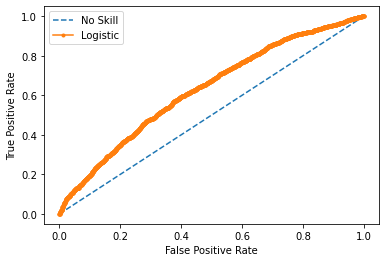

In [278]:
# I just took this code from somewhere online, I wanted to find a way to make and roc curve with statsmodel but 
# couldnt figure out how
validation_set = full_dataset[-110000:-100000]
validation_df = validation_set[columns]
validation_df = normalize(validation_df)
X_test = validation_df.drop(columns=['loan_status'])
y_test = validation_df['loan_status']
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [21]:
X

array([[9.69476134e-01, 0.00000000e+00, 9.32188590e-06, ...,
        3.35587892e-04, 1.39828289e-04, 9.32188590e-06],
       [9.14839866e-01, 0.00000000e+00, 0.00000000e+00, ...,
        8.23355879e-04, 2.05838970e-04, 2.28709967e-05],
       [7.87053213e-01, 0.00000000e+00, 0.00000000e+00, ...,
        2.95144955e-04, 1.08219817e-04, 4.91908258e-06],
       ...,
       [9.04155547e-01, 0.00000000e+00, 0.00000000e+00, ...,
        8.79718910e-04, 5.13169364e-04, 2.44366364e-05],
       [9.88919813e-01, 0.00000000e+00, 2.41199954e-05, ...,
        8.68319836e-04, 4.34159918e-04, 2.41199954e-05],
       [9.52835931e-01, 0.00000000e+00, 9.01453104e-06, ...,
        5.40871862e-04, 2.07334214e-04, 9.01453104e-06]])